# Normalize crops across image space

In [1]:
from functions.crop_image import random_crop
from functions.load_all_data import load_data_by_color, load_labeled_data
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import os
os.chdir("/raid/data/BBBC038/training/")

In [2]:
purple_png_list, purple_img_paths, purple_mask_colls = load_data_by_color(color="Purple")
def_png_list, def_img_paths, def_mask_colls = load_data_by_color(color="Default")

In [59]:
training_samples = []
training_labels = []

test_samples = []
test_labels = []

for i in range(100):
    # take 100 random crops of random images in the purple and default sets
    # take samples from first half of respective data sets
    
    def_idx = np.random.randint(0, len(def_img_paths) / 2)
    purp_idx = np.random.randint(0, len(purple_img_paths) / 2)
    
    def_img = io.imread(def_img_paths[def_idx])
    purp_img = io.imread(purple_img_paths[purp_idx])
    
    def_img = random_crop(def_img)
    purp_img = random_crop(purp_img)
    
    training_samples.append(def_img)
    training_samples.append(purp_img)
    
    training_labels.append(0)
    training_labels.append(1)
    
for i in range(50):
    # take 50 random crops of random images in the other half of the image sets
    
    def_idx = np.random.randint(len(def_img_paths) / 2, len(def_img_paths))
    purp_idx = np.random.randint(len(purple_img_paths) / 2, len(purple_img_paths))
    
    def_img = io.imread(def_img_paths[def_idx])
    purp_img = io.imread(purple_img_paths[purp_idx])
    
    def_img = random_crop(def_img)
    purp_img = random_crop(purp_img)
    
    
    test_samples.append(def_img)
    test_samples.append(purp_img)
    
    test_labels.append(0)
    test_labels.append(1)


/opt/tljh/user/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


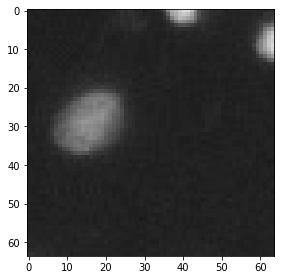

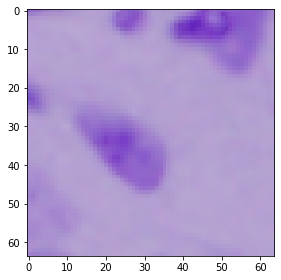

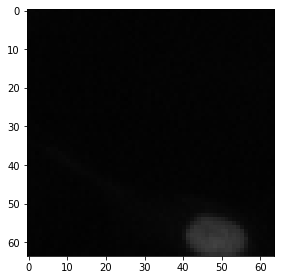

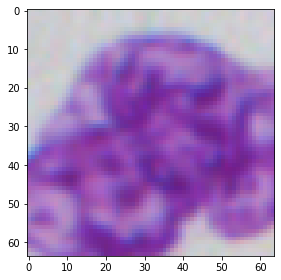

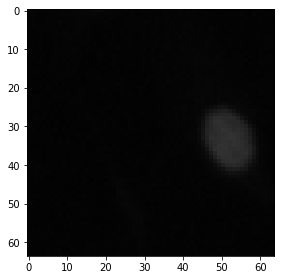

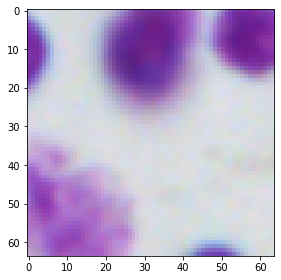

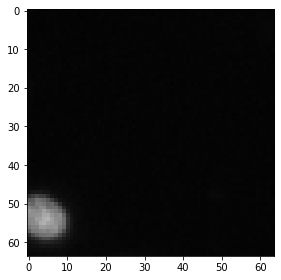

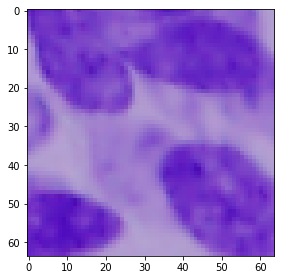

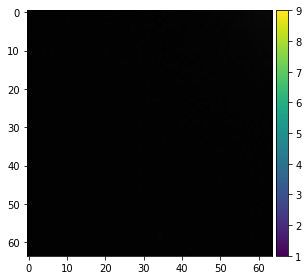

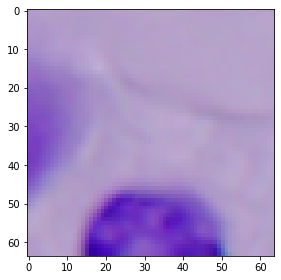

<Figure size 432x288 with 0 Axes>

In [4]:
count = 0
for i in training_samples:
    io.imshow(i)
    plt.figure()

    if count == 9: 
        break
    
    count += 1

In [60]:
training_samples = np.array(training_samples)
training_labels = np.array(training_labels)

test_samples = np.array(test_samples)
test_labels = np.array(test_labels)

training_samples = training_samples / 255.
test_samples = test_samples / 255.

In [6]:
from functions.tf_config import config_gpu

config_gpu(5, True)

8 Physical GPUs, 1 Logical GPU
Configured to run on GPU 5


In [7]:
# training_samples, test_samples = training_samples / 255., test_samples / 255.

In [61]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(3, 3, input_shape=(64, 64, 3), activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Flatten(input_shape=(64,64,3))
])

In [62]:
predictions = model(training_samples).numpy()
predictions

array([[0.0000000e+00, 0.0000000e+00, 9.7607677e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.1606371e-02, ..., 1.8213712e-02,
        2.1946162e-02, 1.2549408e-02],
       [0.0000000e+00, 0.0000000e+00, 3.6297678e-03, ..., 8.6604402e-04,
        1.0435183e-03, 5.9671194e-04],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0519266e-02, ..., 1.7134288e-02,
        2.0645536e-02, 1.1805676e-02],
       [0.0000000e+00, 0.0000000e+00, 7.8518590e-04, ..., 1.2920710e-03,
        1.5568489e-03, 8.9024822e-04],
       [0.0000000e+00, 0.0000000e+00, 1.1947775e-02, ..., 1.7893188e-02,
        2.1559952e-02, 1.2328563e-02]], dtype=float32)

In [63]:
tf.nn.softmax(predictions).numpy()

array([[2.0320515e-06, 2.0320515e-06, 2.0322500e-06, ..., 2.0320515e-06,
        2.0320515e-06, 2.0320515e-06],
       [2.0185239e-06, 2.0185239e-06, 2.0420880e-06, ..., 2.0556256e-06,
        2.0633124e-06, 2.0440148e-06],
       [2.0310783e-06, 2.0310783e-06, 2.0384639e-06, ..., 2.0328380e-06,
        2.0331988e-06, 2.0322907e-06],
       ...,
       [2.0178406e-06, 2.0178406e-06, 2.0391790e-06, ..., 2.0527127e-06,
        2.0599330e-06, 2.0418038e-06],
       [2.0312120e-06, 2.0312120e-06, 2.0328075e-06, ..., 2.0338382e-06,
        2.0343766e-06, 2.0330210e-06],
       [2.0171701e-06, 2.0171701e-06, 2.0414152e-06, ..., 2.0535883e-06,
        2.0611321e-06, 2.0421928e-06]], dtype=float32)

In [64]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss_fn(test_labels[:1], predictions[:1]).numpy()

20.598196

In [65]:
model.compile(optimizer='Adam',
             loss=loss_fn,
             metrics=['accuracy'])

In [66]:
model.fit(training_samples, training_labels, epochs=8)

Epoch 1/8
7/7 [==============================] - 0s 38ms/step - loss: 20.3237 - accuracy: 0.0750
Epoch 2/8
7/7 [==============================] - 0s 37ms/step - loss: 15.3760 - accuracy: 0.4200
Epoch 3/8
7/7 [==============================] - 0s 37ms/step - loss: 13.1397 - accuracy: 0.4900
Epoch 4/8
7/7 [==============================] - 0s 37ms/step - loss: 13.1063 - accuracy: 0.5000
Epoch 5/8
7/7 [==============================] - 0s 36ms/step - loss: 13.1063 - accuracy: 0.5000
Epoch 6/8
7/7 [==============================] - 0s 36ms/step - loss: 13.1063 - accuracy: 0.5000
Epoch 7/8
7/7 [==============================] - 0s 37ms/step - loss: 13.1063 - accuracy: 0.5000
Epoch 8/8
7/7 [==============================] - 0s 37ms/step - loss: 13.1063 - accuracy: 0.5000


In [67]:
model.evaluate(test_samples, test_labels, verbose=2)

4/4 - 0s - loss: 13.1063 - accuracy: 0.5000


[13.106298446655273, 0.5]